In [2]:
#trying to test 3 different methods: normal (x,y), Pipeline, and the train test manually


import pandas as pd #for viewing and changing dataset
from xgboost import XGBRegressor # model 
import matplotlib.pyplot as plt # used with seaborn to plot data
import seaborn as sns # to plot data
from sklearn.model_selection import train_test_split # to split the train and test data
from sklearn.metrics import mean_absolute_error # to find MAE
from sklearn.model_selection import cross_val_score # to test the modell across the whole dataset
from sklearn.pipeline import Pipeline # to make th whole process eaiser in the end 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df = pd.read_csv('cosmetics_sales_data.csv') # loading data
df.head()

,Sales Person,Country,Product,Date,Amount ($),Boxes Shipped
0,Lucas Verma,Canada,Aloe Vera Gel,2022-04-30,7897.13,358
1,Ethan Reddy,UK,Aloe Vera Gel,2022-01-25,16376.88,449
2,Ananya Gupta,India,Body Butter Cream,2022-08-22,5599.68,264
3,Ananya Gupta,New Zealand,Salicylic Acid Cleanser,2022-08-26,2966.47,144
4,Sophia Nair,UK,Body Butter Cream,2022-05-19,6828.68,484


In [3]:
#prediction target
y = df['Amount ($)']
# features
features = ['Sales Person', 'Country', 'Product', 'Boxes Shipped']
X = df[features]

In [4]:
# we will have to encode the Sales Person, Country and Product columns.
# first we need to find the columns with the objects 
s = (X.dtypes =='object')
objects = list(s[s].index) # finds 




encoded_X = X.copy()

encoder = OrdinalEncoder()
encoded_X[objects] =encoder.fit_transform(X[objects])


In [5]:
#findout how many columns are not filled to see if we need to do any preprocessing
count = df.columns.isnull().sum()
print(f'there are {count} missing values')

there are 0 missing values


In [6]:
# Now we'll try to find what the mae is without doing test or validation data data or anything or without optiminng our model 
plain_model = XGBRegressor() # since no changes has been done to optimize performance we jsut call it plain model
plain_model.fit(encoded_X,y)
plain_predicted = plain_model.predict(encoded_X) 
print(mean_absolute_error(plain_predicted, y)) # prints the average error 
df['plain_predicted'] = plain_model.predict(encoded_X) # adds to the data frame every predicted value
df.head()

73.98063916864245


,Sales Person,Country,Product,Date,Amount ($),Boxes Shipped,plain_predicted
0,Lucas Verma,Canada,Aloe Vera Gel,2022-04-30,7897.13,358,7994.244629
1,Ethan Reddy,UK,Aloe Vera Gel,2022-01-25,16376.88,449,16417.767578
2,Ananya Gupta,India,Body Butter Cream,2022-08-22,5599.68,264,5647.501953
3,Ananya Gupta,New Zealand,Salicylic Acid Cleanser,2022-08-26,2966.47,144,2972.587646
4,Sophia Nair,UK,Body Butter Cream,2022-05-19,6828.68,484,6853.243164


In [7]:
#now we will the with train and test
X_train, X_valid, y_train, y_valid = train_test_split(encoded_X,y, random_state=0 ,train_size=0.8, test_size=0.2)

# this time we will try to optimize  he model 
def which_model_is_better(i):
    model2 = XGBRegressor(n_estimators=i, learning_rate=0.01) # we try and change the n_estimators and learning rate
    model2.fit(X_train,y_train)
    predicted2 = model2.predict(X_valid)
    print(f'{i} estimators and the MAE is {mean_absolute_error(predicted2,y_valid)}')
    
for estimators in [10, 20, 30, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]: # trying to see which esitmator is best
    which_model_is_better(estimators)

10 estimators and the MAE is 4458.563326302083
20 estimators and the MAE is 4223.595005208333
30 estimators and the MAE is 4035.965200520833
50 estimators and the MAE is 3709.5659070312495
100 estimators and the MAE is 3101.221166796875
200 estimators and the MAE is 2576.2222391276036
300 estimators and the MAE is 2424.5041573242183
400 estimators and the MAE is 2435.539139615885
500 estimators and the MAE is 2462.7269399739585
600 estimators and the MAE is 2495.3416273763014
700 estimators and the MAE is 2501.905298421224
800 estimators and the MAE is 2516.2912767903645
900 estimators and the MAE is 2520.722949967448
1000 estimators and the MAE is 2540.6018137858073


In [8]:
#quite dissapointing its much worse than the default we will try with a pipeline now 
# since we dont have any numerical values missing we dont need a numerical transformer

categorial_transformer = Pipeline(steps=[('one hot', OneHotEncoder(handle_unknown='ignore'))])# takes the categorial columns and one hot encodes them

preprocessor = ColumnTransformer(transformers=[('cat',categorial_transformer, objects)]) # tells the collumn transformer which columns needs to be changed

mod3l = XGBRegressor(n_estimators=10000, learning_rate=0.05) #trying 10000 estimators and a new learning rate

the_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', mod3l)]) #adding the preporcessor and mod3l to the 

the_pipeline.fit(encoded_X, y) # using the whole data set so i can put it into the dataframe and plot it

Predicted3 = the_pipeline.predict(encoded_X) 

print(mean_absolute_error(Predicted3,y))

df['mod3l_predictions'] = the_pipeline.predict(encoded_X)

df.head()



960.2490436525394


,Sales Person,Country,Product,Date,Amount ($),Boxes Shipped,plain_predicted,mod3l_predictions
0,Lucas Verma,Canada,Aloe Vera Gel,2022-04-30,7897.13,358,7994.244629,7897.120117
1,Ethan Reddy,UK,Aloe Vera Gel,2022-01-25,16376.88,449,16417.767578,16376.877930
2,Ananya Gupta,India,Body Butter Cream,2022-08-22,5599.68,264,5647.501953,5599.689453
3,Ananya Gupta,New Zealand,Salicylic Acid Cleanser,2022-08-26,2966.47,144,2972.587646,2966.450439
4,Sophia Nair,UK,Body Butter Cream,2022-05-19,6828.68,484,6853.243164,6828.681152


I honestly dont know why the default has a much lower mean but its gonna be eaiser when to understand whe nwe plot the figure

In [9]:
import datetime

df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")

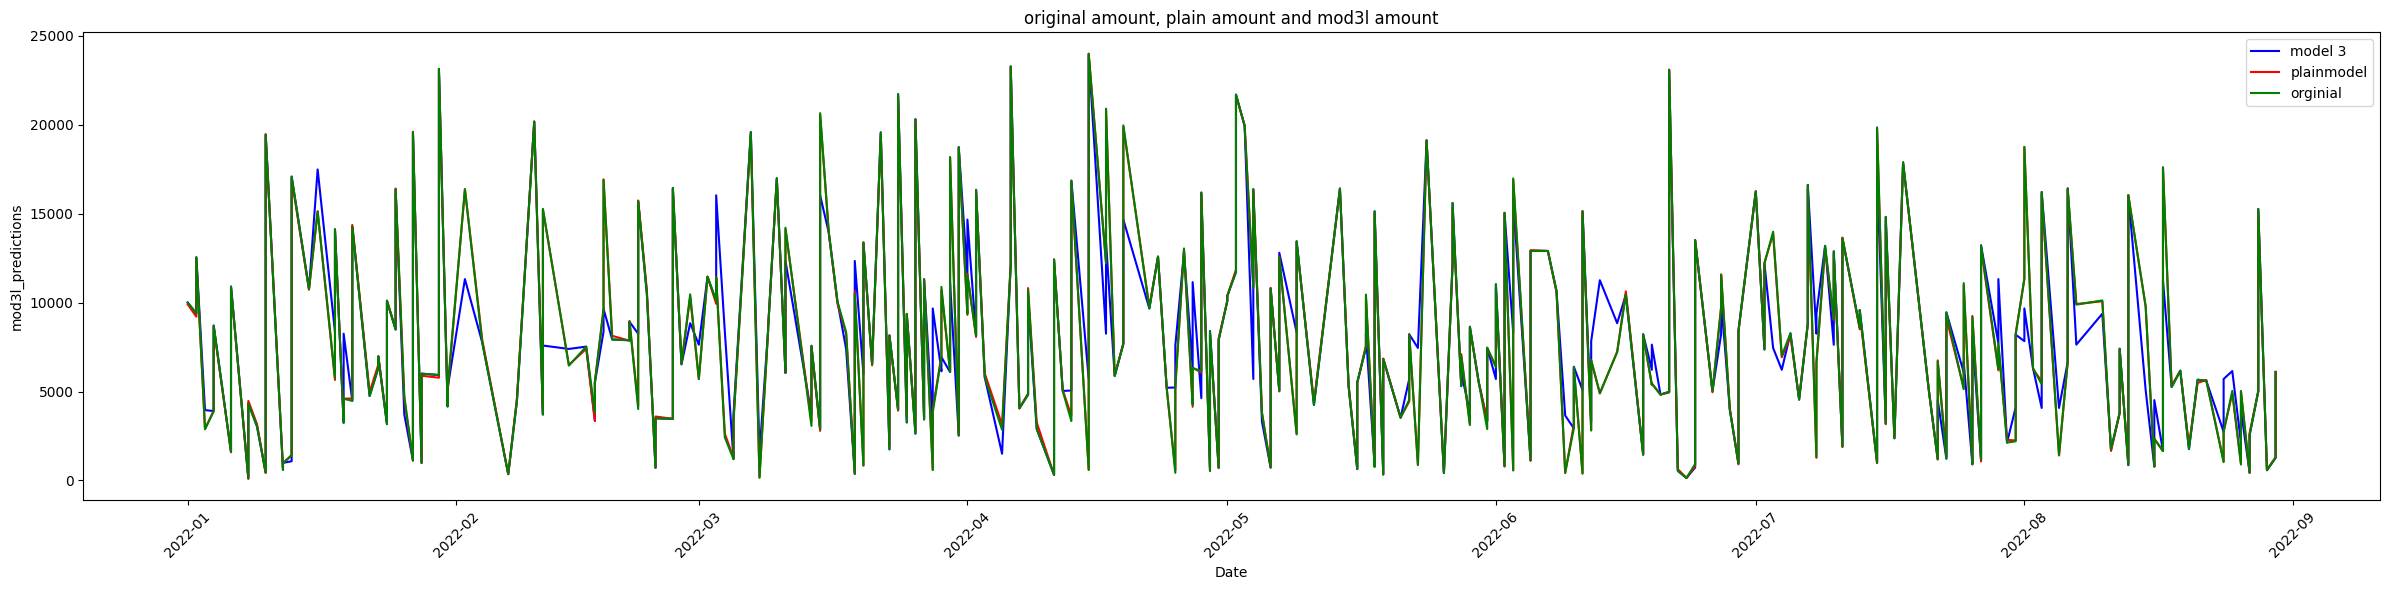

In [10]:
plt.figure(figsize=(24,6))
sns.lineplot(data=df, x='Date', y='mod3l_predictions', label='model 3',color='blue',estimator=None,)
sns.lineplot(data=df, x='Date', y='plain_predicted', label='plainmodel',color='red',estimator=None,)
sns.lineplot(data=df, x='Date', y='Amount ($)',label='orginial',color='green',estimator=None,)
plt.title('original amount, plain amount and mod3l amount')
plt.xticks(rotation=45)
plt.tight_layout()


# Verdict

I still dont know why the plain model is so good compared to the model 3 we can see it follows its almost perfectly as its not visible and the blue line has errors at some points but mostly consistent sometimes it has uptrends when theres down trends which woulndt be favorable